In [1]:
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import pyqg
import torch
from scipy.stats import pearsonr

import sys
sys.path.append('..')

from generate_dataset import PYQGSubgridDataset, generate_parameterized_dataset
from models import FullyCNN
from plot_helpers import figure_grid

%matplotlib inline

# Load datasets generated using `generate_dataset`

In [2]:
# The `PYQGSubgridDataset` class contains helpers for loading netcdf datasets of pyqg runs
# sampled at various time intervals from a series of nested subdirectories. This is mostly
# a thin wrapper around `xr.load_mfdataset`.

train = PYQGSubgridDataset('/scratch/zanna/data/pyqg/datasets/train')
test = PYQGSubgridDataset('/scratch/zanna/data/pyqg/datasets/test')

train.q1.shape, test.q1.shape

((41500, 64, 64), (2175, 64, 64))

In [3]:
# We can get variables from these datasets using the  `extract_variable` and
# `extract_variables` helpers.

X_train = train.extract_variables(['u','v','q'], z=0)
Y_train = train.extract_variables(['q_forcing_advection'], z=0)
X_train.shape, Y_train.shape

((41500, 3, 64, 64), (41500, 1, 64, 64))

In [4]:
X_test = test.extract_variables(['u','v','q'], z=0)
Y_test = test.extract_variables(['q_forcing_advection'], z=0)
X_test.shape, Y_test.shape

((2175, 3, 64, 64), (2175, 1, 64, 64))

In [5]:
# You can also directly access the underlying xarray dataset, if that's more convenient

train.dataset

,Array,Chunk
Bytes,1.27 GiB,5.19 MiB
Shape,"(250, 166, 2, 64, 64)","(1, 166, 2, 64, 64)"
Count,1518 Tasks,250 Chunks
Type,float32,numpy.ndarray
,Array,Chunk
Bytes,1.27 GiB,5.19 MiB
Shape,"(250, 166, 2, 64, 64)","(1, 166, 2, 64, 64)"
Count,1518 Tasks,250 Chunks
Type,float32,numpy.ndarray
,Array,Chunk


# Load models trained using `train_model`

These models have been trained to predict a z-scored version of `q_forcing_advection` on the training set from `u`, `v`, and `q`. When calling `predict`, they automatically rescale their inputs and outputs based on the saved z-scores.

In [6]:
# Use the GPU if it's available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Load upper layer model
cnn1 = FullyCNN(3,1)
cnn1.load('/scratch/zanna/data/pyqg/models/fullycnn/0/model_z0')
cnn1.to(device)

# Load lower layer model
cnn2 = FullyCNN(3,1)
cnn2.load('/scratch/zanna/data/pyqg/models/fullycnn/0/model_z1')
cnn2.to(device)

FullyCNN(
  (0): Conv2d(3, 128, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (1): ReLU()
  (2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (3): Conv2d(128, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (4): ReLU()
  (5): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (6): Conv2d(64, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (7): ReLU()
  (8): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (9): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (10): ReLU()
  (11): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (12): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (13): ReLU()
  (14): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (15): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (16): ReLU()
  (17): BatchNorm2d(32, 

# Predict upper layer subgrid forcing on the test set

In [7]:
Y_pred = cnn1.predict(X_test, device=device)
Y_pred.shape

(2175, 1, 64, 64)

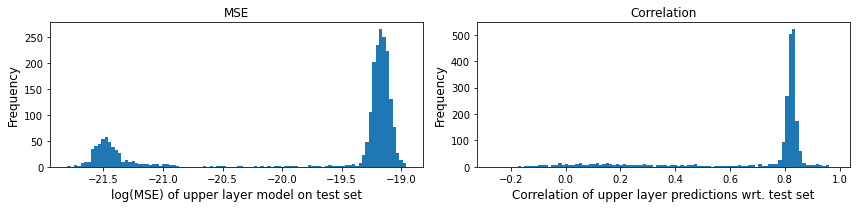

In [8]:
mses = ((Y_pred - Y_test)**2).reshape(-1, 64*64).sum(axis=1)
corrs = [pearsonr(yp.ravel(), yt.ravel())[0] for yp, yt in zip(Y_pred, Y_test)]

with figure_grid(1,2) as g:
    g.next("MSE")
    plt.hist(np.log10(mses), bins=100)
    plt.xlabel("log(MSE) of upper layer model on test set", fontsize=12)
    plt.ylabel("Frequency", fontsize=12)
    
    g.next("Correlation")
    plt.hist(corrs, bins=100)
    plt.xlabel("Correlation of upper layer predictions wrt. test set", fontsize=12)
    plt.ylabel("Frequency", fontsize=12)

Overall, we do reasonably well on a large fraction of the test set, though our correlation is somewhat low for some of the samples. These samples turn out to be in the transient, low $|q|$ states at the beginnings of each simulation, which we can see if we plot correlation or MSE vs. time:

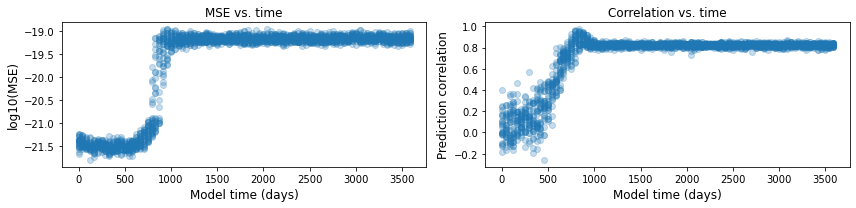

In [36]:
time = test.time / np.timedelta64(1, 'D')

with figure_grid(1,2) as g:
    g.next("MSE vs. time")
    plt.scatter(time.astype(int), np.log10(mses), alpha=0.25)
    plt.xlabel("Model time (days)", fontsize=12)
    plt.ylabel("log10(MSE)", fontsize=12)
    
    g.next("Correlation vs. time")
    plt.scatter(time.astype(int), corrs, alpha=0.25)
    plt.xlabel("Model time (days)", fontsize=12)
    plt.ylabel("Prediction correlation", fontsize=12)

plt.show()

At the beginning of simulations, our predictions are less correlated but our MSE is much lower. At the end, our MSE is higher but our predictions have better correlation with the target.

## Examine individual predictions

In [ ]:
indexes = np.random.choice(len(X_test), size=5)
with figure_grid(len(indexes),3, rowwidth=12, rowheight=3) as g:
    g.title("Predictions vs. ground-truth (offline)")
    for i in indexes:
        q = X_test[i][-1]
        Sq = Y_test[i][0]
        pred = Y_pred[i][0]
        vlim = np.abs(Sq).max()
        g.next(title="$q$")
        plt.imshow(q, cmap='bwr', vmin=-np.abs(q).max(), vmax=np.abs(q).max())
        plt.colorbar()
        g.next(title="$S_q$")
        plt.imshow(Sq, cmap='bwr', vmin=-vlim, vmax=vlim)
        plt.colorbar()
        g.next(title=f"Prediction\n(corr = {pearsonr(Sq.ravel(), pred.ravel())[0]:.2f})")
        plt.imshow(pred, cmap='bwr', vmin=-vlim, vmax=vlim)
        plt.colorbar()

# Run a parameterization online in `pyqg`

We can use the `generate_parameterized_dataset` helper to use these models within the context of a running parameterization. Note that this assumes we're using a version of `pyqg` currently stored at `/scratch/zanna/code/asr9645/pyqg`, or at <https://github.com/asross/pyqg/tree/add_parameterizations>. We should plan to make a pull request to `pyqg` soon that adds the capability for parameterizations, maybe after discussing the interface a bit more!

In [53]:
ds = generate_parameterized_dataset(cnn1, cnn2, 'u,v,q')

INFO:  Logger initialized
INFO: Step: 1000, Time: 3.60e+06, KE: 9.16e-06, CFL: 0.011
INFO: Step: 2000, Time: 7.20e+06, KE: 2.38e-05, CFL: 0.017
INFO: Step: 3000, Time: 1.08e+07, KE: 4.73e-05, CFL: 0.022
INFO: Step: 4000, Time: 1.44e+07, KE: 4.35e-05, CFL: 0.020
INFO: Step: 5000, Time: 1.80e+07, KE: 5.79e-05, CFL: 0.020
INFO: Step: 6000, Time: 2.16e+07, KE: 8.36e-05, CFL: 0.023
INFO: Step: 7000, Time: 2.52e+07, KE: 1.14e-04, CFL: 0.026
INFO: Step: 8000, Time: 2.88e+07, KE: 1.58e-04, CFL: 0.026
INFO: Step: 9000, Time: 3.24e+07, KE: 1.99e-04, CFL: 0.026
INFO: Step: 10000, Time: 3.60e+07, KE: 2.60e-04, CFL: 0.035
INFO: Step: 11000, Time: 3.96e+07, KE: 3.04e-04, CFL: 0.040
INFO: Step: 12000, Time: 4.32e+07, KE: 3.76e-04, CFL: 0.037
INFO: Step: 13000, Time: 4.68e+07, KE: 4.12e-04, CFL: 0.039
INFO: Step: 14000, Time: 5.04e+07, KE: 4.46e-04, CFL: 0.046
INFO: Step: 15000, Time: 5.40e+07, KE: 4.70e-04, CFL: 0.044
INFO: Step: 16000, Time: 5.76e+07, KE: 4.99e-04, CFL: 0.049
INFO: Step: 17000, Time

After running the simulation, we get out an `xarray` dataset showing the results, which makes it easy to plot quantities during the run:

Text(0.5, 1.0, 'Final potential vorticity, upper layer')

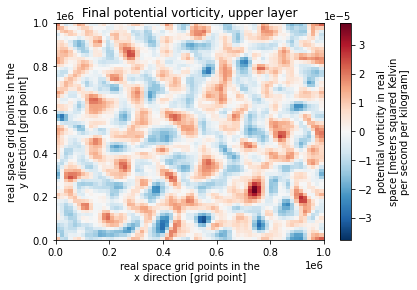

In [71]:
ds.q.isel(lev=0, time=-1).plot()
plt.title("Final potential vorticity, upper layer")

We can also examine time-averaged spectra from the run:

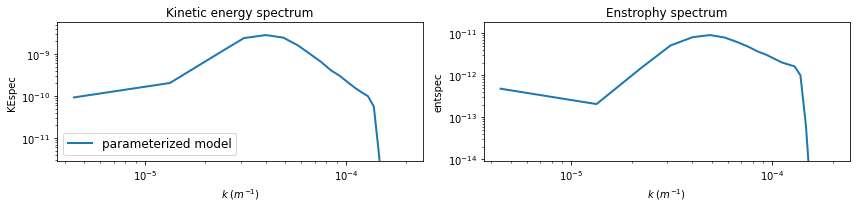

In [67]:
from plot_helpers import plot_spectra

# Add a run dimension and plot attributes, as this particular
# plot helper assumes we are comparing a set of results of many runs
ds = ds.expand_dims(dim='run').assign_attrs(plot_kwargs=dict(label='parameterized model'))

with figure_grid(1,2) as g:
    g.next(title="Kinetic energy spectrum")
    plot_spectra('KEspec', [ds], z='sum')
    
    g.next(title="Enstrophy spectrum")
    plot_spectra('entspec', [ds], leg=False)